#Basic Setup and configuration

In [ ]:
# import cv2
# print(cv2.__version__)

4.10.0


In [ ]:
#install kaggle

!pip install kaggle

In [ ]:
from google.colab import drive


#Mount gdrive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!ls

gdrive	model.png  sample_data


In [ ]:
import os

#path
root = '/content/gdrive/My Drive/Machine learning'
KaggleKeyJsonPath = os.path.join(root, "kaggle")

#set the environment variables
os.environ['KAGGLE_CONFIG_DIR'] = KaggleKeyJsonPath

#cd so the download will be in the right folder
%cd "/content/gdrive/My Drive/Machine learning/Class Deep Learning/kaggle Dataset"




/content/gdrive/My Drive/Machine learning/Class Deep Learning/kaggle Dataset


In [ ]:
#download kaggle dataset
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

In [ ]:
#unzip it
!unzip brain-mri-images-for-brain-tumor-detection.zip -d "/content/gdrive/My Drive/Machine learning/Class Deep Learning/kaggle Dataset/BrainMRI"

print(os.getcwd())

Archive:  brain-mri-images-for-brain-tumor-detection.zip
replace /content/gdrive/My Drive/Machine learning/Class Deep Learning/kaggle Dataset/BrainMRI/brain_tumor_dataset/no/1 no.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: /content/gdrive/My Drive/Machine learning/Class Deep Learning/kaggle Dataset


#Data preparation

In [ ]:
import os

os.getcwd()
!ls

#setup root path var
path_dataset = os.path.join(os.getcwd(), 'BrainMRI/brain_tumor_dataset')

BrainMRI					LabelNp_2.npy
brain-mri-images-for-brain-tumor-detection.zip	LabelNp.npy
cnn_model_1.h5					model.png
cnn_model_1.keras				vgg16_pretrained.keras
cnn_model_2.keras				visualize_model_structure.png
cnn_model_3.keras				Xtrain_split.npy
DataNp_2.npy					Xval_split.npy
DataNp.npy					ytrain_split.npy
hLabelNp_2.npy					yval_split.npy
hLabelNp.npy


In [ ]:
#1st method (but in this class we not used)
#used Datagenerator
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#if we used standard image from alexNet etc but generally people just divide by 255 for normalization but for faster converge for using pre-trained model we need to normalize with
#value std and mean from ImageNet/CIFar or the image that they used
# Define the mean and std for each channel (e.g., from ImageNet)
mean = np.array([0.485, 0.456, 0.406])  # R,G,B means for 3 channel,
std = np.array([0.229, 0.224, 0.225])   # R,G,B stds for 3 channel,

# Custom preprocessing function to normalize by mean and std
def normalize_image(image):
    # Scale pixel values to [0, 1] by dividing by 255
    image = image / 255.0

    # Subtract mean and divide by std (per channel)
    image = (image - mean) / std
    return image



#since this data only consist of 1 meaning only 1 data no separate folders for traing and validation
dataGen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
# dataGen = ImageDataGenerator(preprocessing_function=normalize_image, validation_split=0.2) #this if we passed the cb

#load the folders
training_generator = dataGen.flow_from_directory(path_dataset, target_size=(224, 224), batch_size=32, class_mode="binary", subset='training')
validation_generator = dataGen.flow_from_directory(path_dataset, target_size=(224,224), batch_size=32, class_mode="binary", subset='validation')

print(type(training_generator), type(validation_generator))


#iterate just check
t_images_np, t_label_np = next(training_generator)
print(t_images_np.shape, t_label_np.shape)




Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
<class 'keras.src.legacy.preprocessing.image.DirectoryIterator'> <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>
(32, 224, 224, 3) (32,)


In [ ]:
#2nd method using scikit test_train
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

#since this we using old school method
#create array then create fn helper but its ok if not, but it needs to run chronologically


def load_dataset(dataset_root_path, size_tuple):
  images=[]
  labels=[]
  class_names = os.listdir(dataset_root_path)
  for index, className in enumerate(class_names):
    print(index)
    for dirent in os.scandir(os.path.join(dataset_root_path, className)):
      if dirent.is_file():
        #load images/convert into numpy
        image = cv2.imread(dirent.path)
        #usually the cv2 will convert to BGR so for tensorflow model we need to RGB format numpy
        imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_normalized = cv2.resize(imageRGB, size_tuple)/255

        #then appends the images aswell the label
        images.append(image_normalized.astype(np.float32))
        labels.append(index) #this is important for correct format for tensorflow model


  # Convert lists to NumPy arrays
  images_array = np.array(images)
  labels_array = np.array(labels, dtype=np.int32)
  hot_encodings = to_categorical(labels_array, num_classes=len(labels_array))

  return images_array, labels_array, hot_encodings, class_names


X, y, Y, class_name = load_dataset(path_dataset, (224,224))

# print(X.shape, y.shape, Y[:10])
print(X.shape, y.shape, Y[:10])



0
1
(253, 224, 224, 3) (253,) [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [ ]:
#continue from second method
import numpy as np

#save so next time we dont need to rerun the code
np.save('DataNp_2', X)
np.save('LabelNp_2', y)
np.save('hLabelNp_2', Y)


In [ ]:
#test load the data
import numpy as np

X_load= np.load('DataNp_2.npy')
y_load = np.load('LabelNp_2.npy')
Y_load = np.load('hLabelNp_2.npy')


print(X_load.shape, y_load.shape)

(253, 224, 224, 3) (253,)


In [ ]:
from sklearn.model_selection import train_test_split
#split using scikit
X_train, X_val, y_train, y_val = train_test_split(X_load, y_load,test_size=0.2, stratify=y_load, shuffle=True, random_state=122)

print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {X_val.shape}, Testing labels shape: {y_val.shape}")


Training data shape: (202, 224, 224, 3), Training labels shape: (202,)
Testing data shape: (51, 224, 224, 3), Testing labels shape: (51,)


In [ ]:
#supposedly we need to do this first
#continue from second method
import numpy as np

#save so next time we dont need to rerun the code
np.save('Xtrain_split', X_train)
np.save('Xval_split', X_val)
np.save('ytrain_split', y_train)
np.save('yval_split', y_val)



#test load the data
import numpy as np

X_load_train= np.load('Xtrain_split.npy')
X_load_val= np.load('Xval_split.npy')
y_load_train= np.load('ytrain_split.npy')
y_load_val= np.load('yval_split.npy')

print(X_load_train.shape, y_load_train.shape)
print(X_load_val.shape, y_load_val.shape)

(202, 224, 224, 3) (202,)
(51, 224, 224, 3) (51,)


#Build Model CNN

In [ ]:
#import library/modules
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, Dense, Dropout, MaxPooling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

#init the model
model = Sequential()

#Adding layers

#add convolution layer
model.add(Conv2D(32, (3,3), input_shape=(224, 224, 3), activation='relu', padding='same'))

#add max pooling
model.add(MaxPooling2D((2,2)))

#add another convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))


#add batch normalization
model.add(BatchNormalization())

#add another max pooling
model.add(MaxPooling2D((2,2)))

#add dropout
# model.add(Dropout(0.5))
model.add(Dropout(0.25))


#flatten so it can fit fit fcn node
model.add(Flatten())

#Create the dense layer just for simple demo i only create single hidden layer of fcn
model.add(Dense(64, activation='relu'))

#add dropout
model.add(Dropout(0.25))
# model.add(Dropout(0.5))
# model.add(Dropout(0.6))


#output layer
# model.add(Dense(2, activation='softmax')) #output layer 2 is because the class only 2 but we need to used sparse_categorical since we used label integer

# OR  Use 1 neuron for binary classification since it only 0 to 1 right
model.add(Dense(1, activation='sigmoid'))


#compile the model add the optimization and learning rate if want  metrics=['accuracy', Precision(), Recall()]
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy', metrics=['accuracy'])

#get summary
model.summary()


#plot the model structure
# plot_model(model, show_shapes=True, show_layer_names=True)
#plot_model(model)
# plot_model(model, to_file='visualize_model_structure.png')





/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │      12,845,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,864,833 (49.08 MB)

 Trainable params: 12,864,705 (49.07 MB)

 Non-trainable params: 128 (512.00 B)

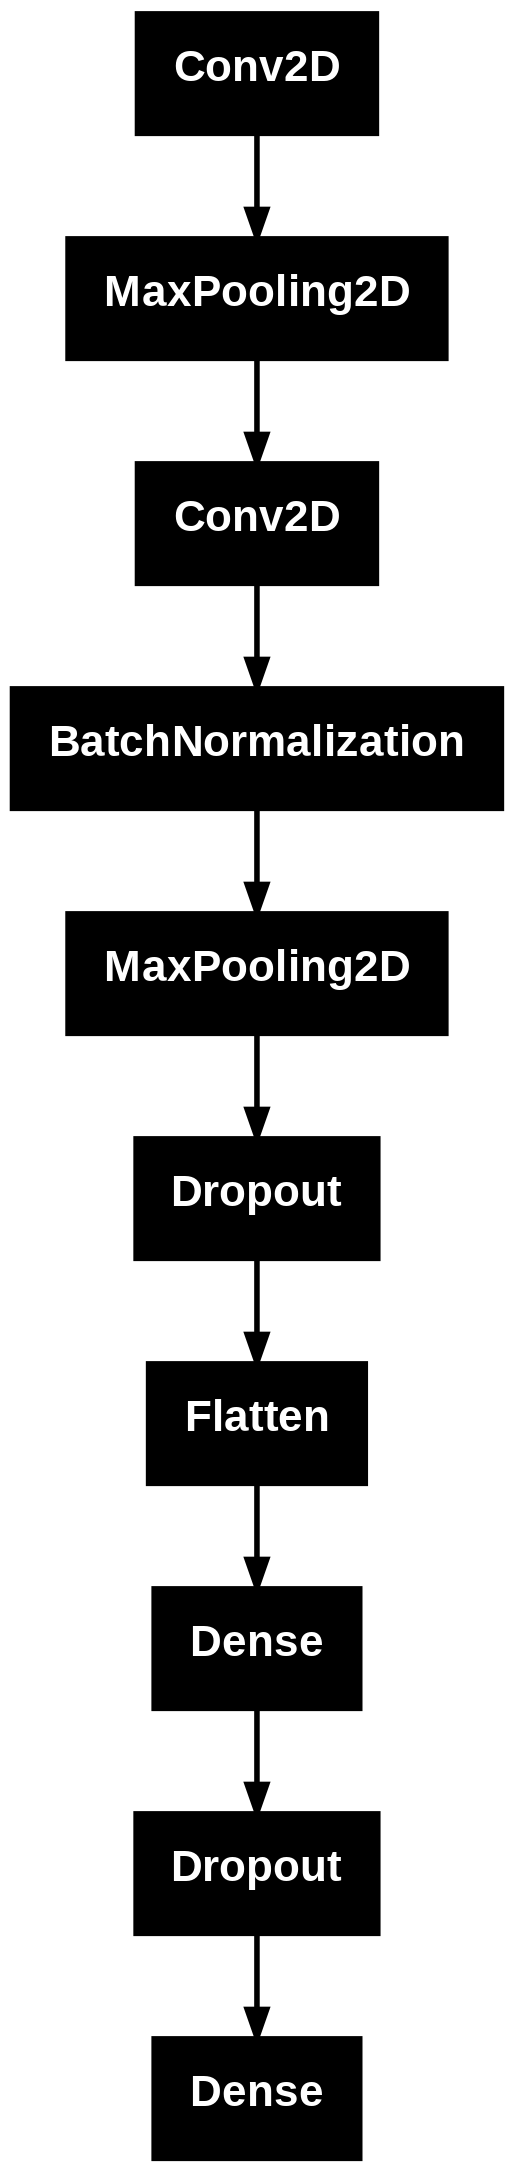

In [ ]:
# Display the image in Colab
from IPython.display import Image
Image('visualize_model_structure.png')


In [ ]:
#training
#cb for callback OPTIONALS
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)
history = model.fit(x=X_load_train, y=y_load_train, batch_size=32, epochs=10, validation_data=(X_load_val, y_load_val), verbose='auto', callbacks=early_stopping)
# history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), verbose='auto', callbacks=early_stopping)
# history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), verbose='auto')

#if we used ImageDataGenerator from tensorflow.keras.preprocessing.image
# model.fit(
#     train_generator,               # Training data generator
#     validation_data=validation_generator,  # Validation data generator
#     epochs=10                      # Number of epochs to train
# )



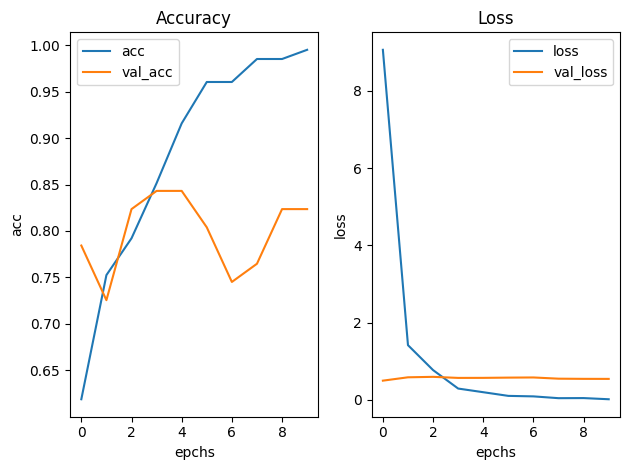

In [ ]:
#import
import matplotlib.pyplot as plt

#get the data
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']


#plot
plt.subplot(1,2,1)
plt.plot(training_accuracy, label='acc')
plt.plot(validation_accuracy, label='val_acc')
plt.title('Accuracy')
plt.xlabel('epchs')
plt.ylabel('acc')
plt.legend()


plt.subplot(1,2,2)
plt.plot(training_loss, label='loss')
plt.plot(validation_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('epchs')
plt.ylabel('loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save the model
# model.save('cnn_model_1.h5')
model.save('cnn_model_3.keras')

In [ ]:
# Load the saved model
import tensorflow as tf
loaded_model = tf.keras.models.load_model('cnn_model_3.keras')

# Evaluate the model on the test/validation data
loss, accuracy = loaded_model.evaluate(X_load_val, y_load_val)

print('accuracy:', round(accuracy*100,2), 'loss:', round(loss*100, 2), )


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 480ms/step - accuracy: 0.8538 - loss: 0.5711
accuracy: 84.31 loss: 56.96


##Test with Val images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step


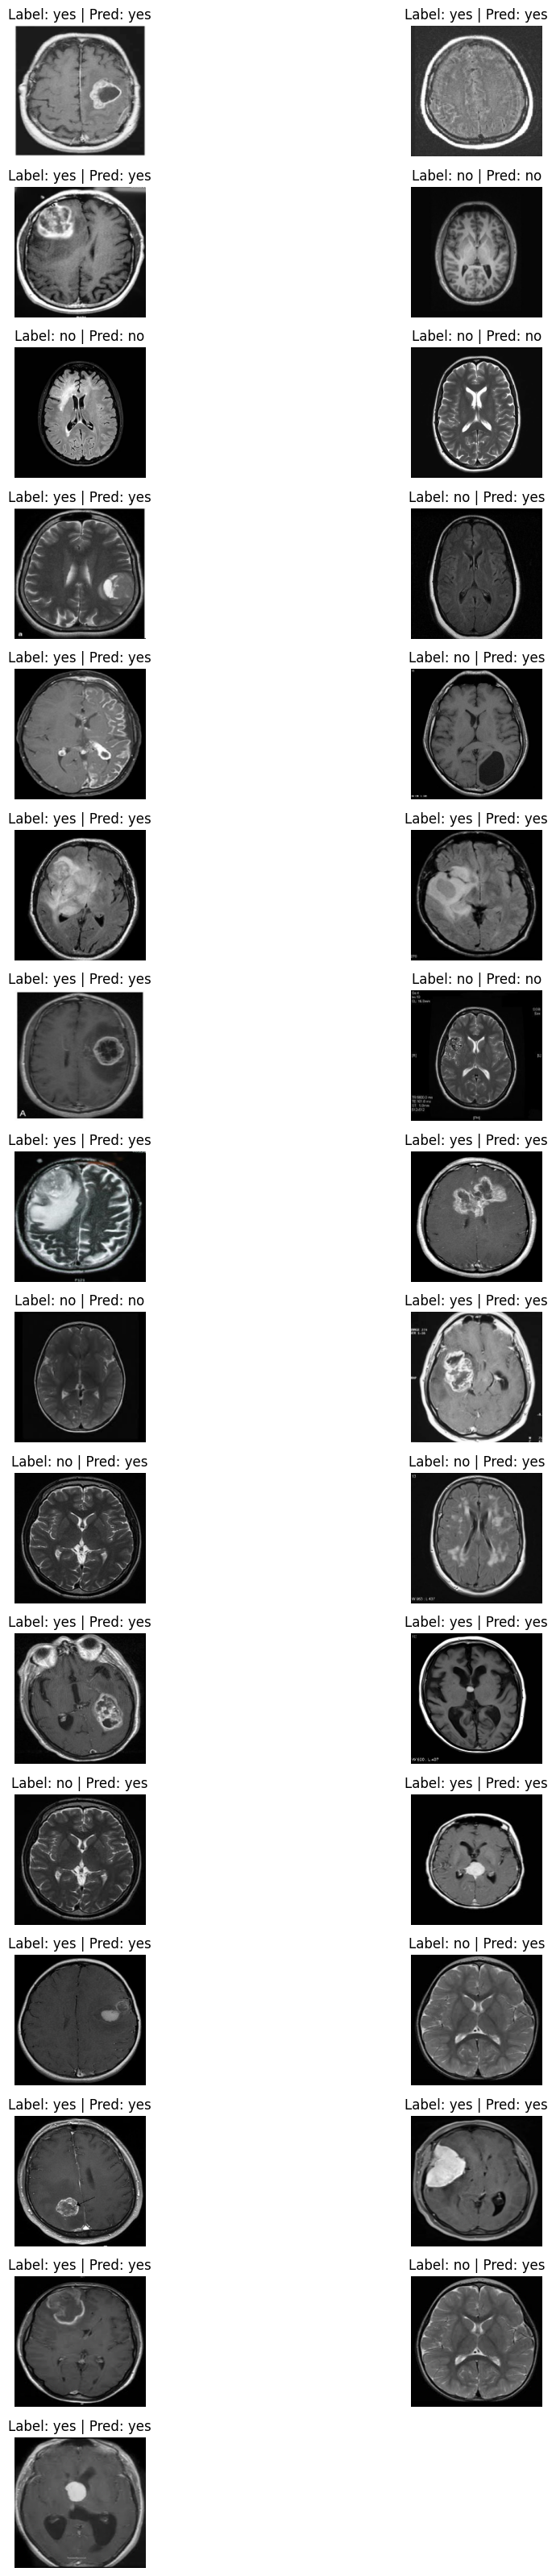

In [ ]:
#import
import matplotlib.pyplot as plt

#predicted test
# numberImage = 45
endImage = 50
startImage = 20
x_val_sample = (X_load_val[startImage:endImage+10]*255).astype("uint8")
y_val_sample = y_load_val[startImage:endImage+10]
threshold = 0.5
classNames = os.listdir(path_dataset)

#make prediction
predictions = loaded_model.predict(x_val_sample)


# def modify_prediction(predictions, threshold=0.5, typeClass='binary'):
#   if(typeClass):
#     prediction_mod = np.where(predictions>0.5, 1, 0)
#   else:
#     return predictions


#loop and show image
plt.figure(figsize=(10, len(x_val_sample) * 2)) # so to make so that fix size
for i in range(len(x_val_sample)):
  # print(predictions[i], y_val_sample[i])
  plt.subplot(len(x_val_sample),2, i+1)
  plt.imshow(x_val_sample[i])
  plt.axis('off')

  # plt.title(f'Label:{y_val_sample[i]} | Pred:{predictions[i][0]} ')
  prediction= predictions[i]
  predicted_label = f"{prediction[0]:.2f}" if isinstance(prediction, np.ndarray) else f"{prediction:.2f}"
  className = ''

  if prediction > (threshold):
      className = classNames[1]
  else:
      className = classNames[0]


  #this is for testing
  # if classNames[y_val_sample[i]] != className:
  #   print('index:', i, classNames[y_val_sample[i]], className, prediction)


  plt.title(f"Label: {classNames[y_val_sample[i]]} | Pred: {className}")


plt.tight_layout()
plt.show()

#Pre-trained model

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,264,641 (512.18 MB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

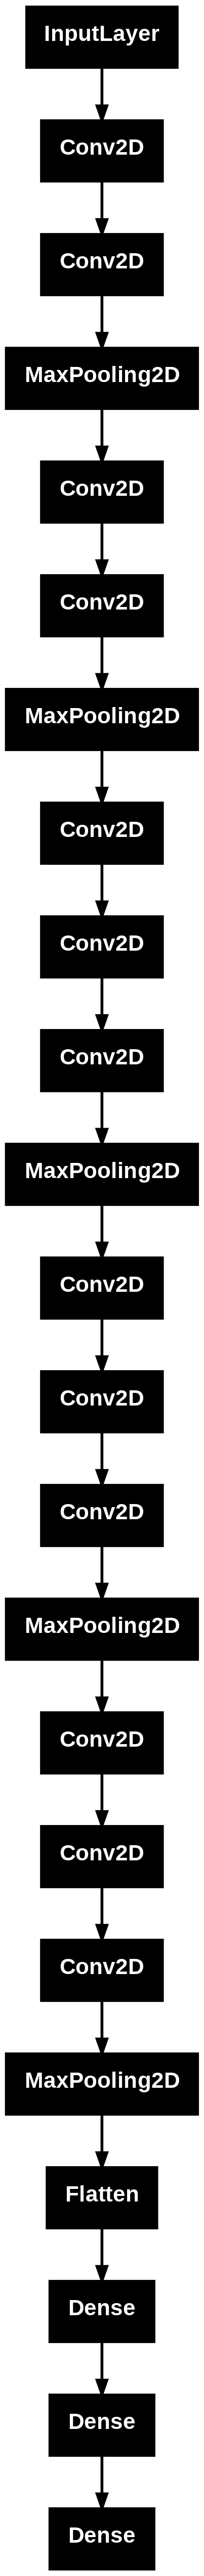

In [ ]:
#Using functional API
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Precision, Recall

#load the model
# vgg = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg = VGG16(weights='imagenet', include_top=True)

#create input
input = vgg.input

#new classification layer
new_classification_layer = Dense(1, activation='sigmoid')


#connect the layer to vgg output tensor
output = new_classification_layer(vgg.layers[-2].output)


#then combine all
pre_trained_model = Model(inputs=input, outputs=output)


#then freeze or not
def pre_trained_mode(model, freeze=True):
  #if freeze meaning we want to keep features only allowed the last layers to change
  if freeze:
    for index, layer in enumerate(model.layers[:-1]):
      layer.trainable = False #freeze all except the last classification layer
  else:
    for index, layer in enumerate(model.layers[:]):
      layer.trainable = True #unfreeze all

#take all the features in this case
pre_trained_mode(pre_trained_model)


#then compile
pre_trained_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])


#print summary
pre_trained_model.summary()


#plot model
plot_model(pre_trained_model)


Load the data that already split

In [ ]:
import numpy as np

X_load_train = np.load('Xtrain_split.npy')
y_load_train = np.load('ytrain_split.npy')
X_load_val = np.load('Xval_split.npy')
y_load_val = np.load('yval_split.npy')

print('Train:', X_load_train.shape, y_load_train.shape, '\n')
print('Val:', X_load_val.shape, y_load_val.shape, '\n')

Train: (202, 224, 224, 3) (202,) 

Val: (51, 224, 224, 3) (51,) 



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

#training
#cb for callback OPTIONALS
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)
history_pre_trained = pre_trained_model.fit(x=X_load_train, y=y_load_train, batch_size=32, epochs=10, validation_data=(X_load_val, y_load_val), verbose='auto', callbacks=early_stopping)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 161s 23s/step - accuracy: 0.6228 - loss: 0.7280 - precision_1: 0.5896 - recall_1: 0.6819 - val_accuracy: 0.3922 - val_loss: 0.7523 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 201s 23s/step - accuracy: 0.5341 - loss: 0.7016 - precision_1: 0.5730 - recall_1: 0.5517 - val_accuracy: 0.6471 - val_loss: 0.6111 - val_precision_1: 0.6327 - val_recall_1: 1.0000
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 188s 21s/step - accuracy: 0.6137 - loss: 0.6343 - precision_1: 0.7179 - recall_1: 0.6468 - val_accuracy: 0.6078 - val_loss: 0.6266 - val_precision_1: 0.6078 - val_recall_1: 1.0000
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 207s 22s/step - accuracy: 0.6095 - loss: 0.6332 - precision_1: 0.6055 - recall_1: 1.0000 - val_accuracy: 0.8235 - val_loss: 0.5855 - val_precision_1: 0.8667 - val_recall_1: 0.8387
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 204s 22s/step - accuracy: 0.7393 - loss: 0.5882 - precision_1: 0.7576 - recall_1: 0.8582 - v

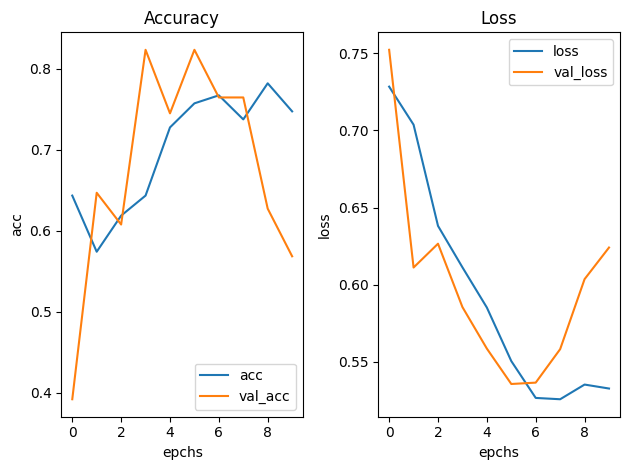

In [ ]:
#import
import matplotlib.pyplot as plt

#get the data
training_accuracy = history_pre_trained.history['accuracy']
validation_accuracy = history_pre_trained.history['val_accuracy']

training_loss = history_pre_trained.history['loss']
validation_loss = history_pre_trained.history['val_loss']


#plot
plt.subplot(1,2,1)
plt.plot(training_accuracy, label='acc')
plt.plot(validation_accuracy, label='val_acc')
plt.title('Accuracy')
plt.xlabel('epchs')
plt.ylabel('acc')
plt.legend()


plt.subplot(1,2,2)
plt.plot(training_loss, label='loss')
plt.plot(validation_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('epchs')
plt.ylabel('loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#save
pre_trained_model.save("vgg16_pretrained.keras")


#load model
loaded_pre_trained_model = tf.keras.models.load_model("vgg16_pretrained.keras")

loss, accuracy, precision, recall = loaded_pre_trained_model.evaluate(X_load_val, y_load_val)



2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 12s/step - accuracy: 0.8407 - loss: 0.5845 - precision_1: 0.8760 - recall_1: 0.8574


In [ ]:
print('accuracy:', round(accuracy,2), 'loss:', round(loss, 2), 'precision:', round(precision,2), "recal:", round(recall,2))

accuracy: 0.82 loss: 0.59 precision: 0.87 recal: 0.84


##Test pre-trained with val image

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


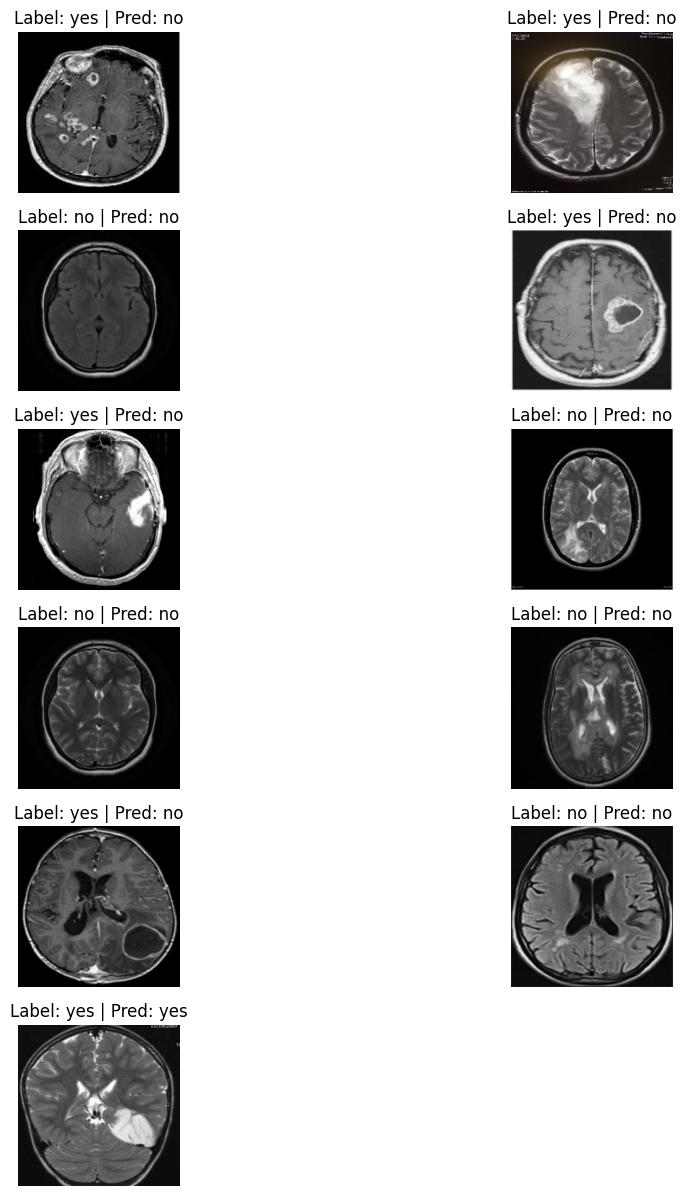

In [ ]:
#import
import matplotlib.pyplot as plt

#predicted test
# numberImage = 45
endImage = 10
startImage = 0
x_val_sample = (X_load_val[startImage:endImage+1]*255).astype("uint8")
y_val_sample = y_load_val[startImage:endImage+1]
threshold = 0.5
classNames = os.listdir(path_dataset)

#make prediction
predictions = loaded_pre_trained_model.predict(x_val_sample)


# def modify_prediction(predictions, threshold=0.5, typeClass='binary'):
#   if(typeClass):
#     prediction_mod = np.where(predictions>0.5, 1, 0)
#   else:
#     return predictions


#loop and show image
plt.figure(figsize=(10, len(x_val_sample) * 2)) # so to make so that fix size
for i in range(len(x_val_sample)):
  # print(predictions[i], y_val_sample[i])
  plt.subplot(len(x_val_sample),2, i+1)
  plt.imshow(x_val_sample[i])
  plt.axis('off')

  # plt.title(f'Label:{y_val_sample[i]} | Pred:{predictions[i][0]} ')
  prediction= predictions[i]
  predicted_label = f"{prediction[0]:.2f}" if isinstance(prediction, np.ndarray) else f"{prediction:.2f}"
  className = ''

  if prediction > (threshold):
      className = classNames[1]
  else:
      className = classNames[0]


  #this is for testing
  # if classNames[y_val_sample[i]] != className:
  #   print('index:', i, classNames[y_val_sample[i]], className, prediction)


  plt.title(f"Label: {classNames[y_val_sample[i]]} | Pred: {className}")


plt.tight_layout()
plt.show()